## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.datasets import load_sample_image

%matplotlib inline

def compare_images(img, img_compressed, k):
    """Show the compressed and uncompressed image side by side.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes[0].set_axis_off()
    if isinstance(k, str):
        axes[0].set_title(k)
    else:
        axes[0].set_title(f"Compressed to {k} colors")
    axes[0].imshow(img_compressed)
    axes[1].set_axis_off()
    axes[1].set_title("Original")
    axes[1].imshow(img)

# K-Means

In this first section you will implement the image compression algorithm from Bishop, chapter 9.1.1. Take an RGB image $X \in \mathbb{R}^{h \times w \times 3}$ and interpret it as a data matrix $X \in \mathbb{R}^{N \times 3}$. Now apply $k$-means clustering to find $k$ colors that describe the image well and replace each pixel with its associated cluster.

In [20]:
# Alternatively try china.jpg
X = load_sample_image("china.jpg")

# or load your own image
# X = np.array(Image.open("/home/user/path/to/some.jpg"))

In [3]:
X[10,10]

array([16, 31, 26], dtype=uint8)

In [25]:
a=np.ones([2,3])
b=np.array([4,5,6])
#c=np.square(a-b)
#d=c.sum(axis=1)
c = np.array([b]).T
d=b.argmin()
d

0

In [47]:
mu = np.random.randint(0,255,[3,5])
mu
print(X.max())

255


In [29]:
def euclidean_dist(Xi, mu):
    """Compute the Euclidean Distance Array of a point to all other mus

     Parameters
    ----------
    Xi : np.array of size D
    mu : np.array of size k x D

    Returns
    -------
    dist : np.array of size k
    """
    squared = np.square(Xi-mu)
    summed = squared.sum(axis=1)
    return np.sqrt(summed)


def kmeans(X, k):
    """Compute a k-means clustering for the data X.

    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters

    Returns
    -------
    mu : np.array of size k x D
        Cluster centers
    z : np.array of size N
        Cluster indicators, i.e. a number in 0..k - 1, for each data point in X
    """

    # TODO: Compute mu and z
    N, D = X.shape

    # Step 1: initialize data points
    mu_arg = np.random.randint(0, N, k)
    mu = X[mu_arg]
    print(mu)
    mu_num = np.zeros(k)
    z = np.zeros(N, dtype=np.uint8)

    # Step 2: iteratively computing labels and clusters until converge
    for i in range(20):
        # Assign clusters to all points
        for j in range(N):
            dist = euclidean_dist(X[j], mu)
            z[j] = dist.argmin()
        # Recompute cluster means
        mu_num = np.ones(k)
        mu = np.zeros_like(mu, dtype=np.uint32)
        for j in range(N):
            mu_num[z[j]] += 1
            mu[z[j]] += X[j]
        mu = np.floor(mu/(np.array([mu_num]).T))
        dist = euclidean_dist(X, mu[z])
    return mu, z

In [18]:
a=np.random.randint(1,10,[3,4])
b=np.array([0,0,0,0])
print(Euclidean_Dist(b,a).argmin())

0


[[126  49  39]
 [ 35  12   6]
 [ 86 114 117]
 [212 219 238]
 [ 51  28  36]]


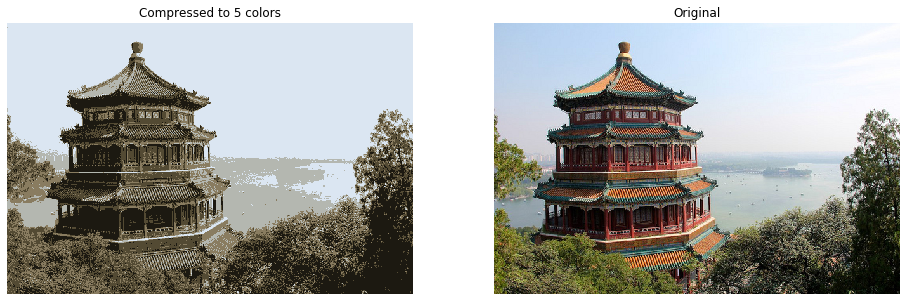

In [33]:
# Cluster the color values
k = 5
mu, z = kmeans(X.reshape((-1, 3)), k)

# Replace each pixel with its cluster color
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Gaussian Mixture Models & EM

Now you will repeat the same exercise with GMMs.

In [76]:
a = np.random.randint(1, 10, [3, 4])
ones = np.ones([3,4])
b = np.random.randint(1, 10, 3)
c = np.random.randint(1, 10, 4)
print(a)
print(a+np.array([ones[:,2]]).T)

[[2 3 5 8]
 [2 3 2 9]
 [5 9 4 1]]
[[ 3.  4.  6.  9.]
 [ 3.  4.  3. 10.]
 [ 6. 10.  5.  2.]]


In [60]:
a=np.array([1,2,3])
b=np.random.randint(1,5,3)
c=np.random.randint(1,5,[3,3])
gaussian_probability(a,b,c)

0.11368481878213187

In [101]:
def gaussian_probability(Xi, mu, sigma):
    """Compute the Gaussian probability for one data point, given parameters.

    Parameters
    ----------
    X : np.array of size D
        where D is the data dimensionality
    mu : np.array of size D
        Mean vectors of the Gaussian component distributions
    sigma : np.array of size D x D
        Covariance matrices of the Gaussian component distributions

    Returns
    -------
    p : constant
    """
    D = mu.size
    p = 1/np.sqrt(((2*np.pi)**D)*np.linalg.det(sigma))
    X_norm = Xi-mu
    p *= np.exp(-0.5*X_norm.dot(np.linalg.inv(sigma)).dot(X_norm))
    return p


def expected_jointLL(PLL_joint):
    """Compute the expectation of a given joint probability matrix.

    Parameters
    ----------
    P_joint : np.array of size N x D
        where D is the data dimensionality

    Returns
    -------
    ELL : float
    """
    P_joint = np.exp(PLL_joint)
    P_summed = P_joint.sum(axis=1)
    ELL = np.sum(np.log(P_summed))
    return ELL


def gmm_log_probability(X, pi, mu, sigma):
    """Compute the joint log-probabilities for each data point and component.

    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions

    Returns
    -------
    P : np.array of shape N x k
        P[i, j] is the joint log-probability of data point i under component j
    """

    # TODO: Compute P
    N, D = X.shape
    k = pi.size
    P = np.zeros((N, k), dtype=np.float16)
    for i in range(N):
        for j in range(k):
            P[i, j] = np.log(
                pi[j])+np.log(gaussian_probability(X[i], mu[j], sigma[j]))
    return P


def em(X, k, tol=0.001):
    """Fit a Gaussian mixture model with k components to X.

    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
    tol : float
        Converge when the increase in the mean of the expected joint log-likelihood
        is lower than this

    The algorithm should stop when the relative improvement in the optimization
    objective is less than rtol.

    Returns
    -------
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    """

    # TODO: Compute pi, mu, sigma
    N, D = X.shape

    # Step 1: Initialze the mu and sigma and pi
    mu_arg = np.random.randint(0, N, k)
    mu = X[mu_arg]
    print("Initialized centroids are: \n", mu)
    sigma = np.ones((k,D,D))*np.eye(D)
    pi = np.ones(k)/k

    # Step 2: EM Algorithm
    ELL_new = tol
    ELL_old = -tol
    # while ELL_new-ELL_old > tol:
    for i in range(2):
        # E Step
        P_gmm = np.exp(gmm_log_probability(X, pi, mu, sigma))
        gamma = P_gmm/np.array([P_gmm.sum(axis=1)]).T
        # M Step
        Nk = gamma.sum(axis=0)
        mu = gamma.T.dot(X)/np.array([Nk]).T
        for i in range(k):
            sigma[i] = np.dot(gamma[:,i]*(X-mu[i]).T, (X-mu[i]))
        pi = Nk/N
        
        ELL_old = ELL_new
        ELL_new = expected_jointLL(gmm_log_probability(X, pi, mu, sigma))

    return pi, mu, sigma

Initialized centroids are: 
 [[201 208 226]
 [213 234 255]
 [108 105  86]
 [ 50  46  47]
 [ 21  24  15]]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


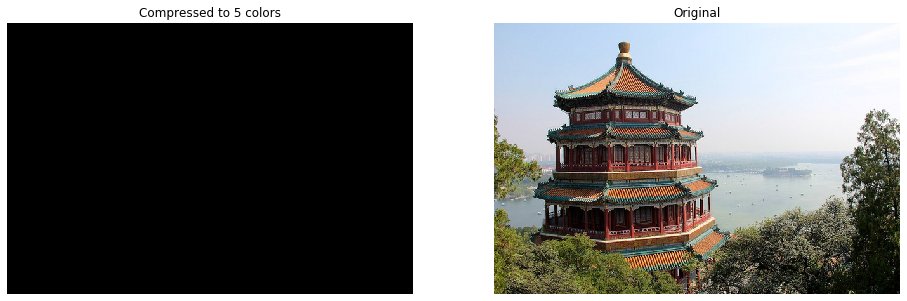

In [103]:
# Fit the GMM
k = 5
pi, mu, sigma = em(X.reshape((-1, 3)), k)

# Determine the most likely cluster of each pixel
log_p = gmm_log_probability(X.reshape((-1, 3)), pi, mu, sigma)
z = log_p.argmax(axis=1)

# Replace each pixel with its cluster mean
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Sampling Unseen Datapoints

You have trained a generative model which allows you to sample from the learned distribution. In this section, you sample new images.

In [ ]:
def gmm_sample(N, pi, mu, sigma):
    """Sample N data points from a Gaussian mixture model.
    
    Parameters
    ----------
    N : int
        Number of data points to sample
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    X : np.array of shape N x D
    """
    
    # TODO: Sample X
    
    
    return X

In [ ]:
# Sample pixels and reshape them into the size of the original image
X_sampled = gmm_sample(np.prod(X.shape[:-1]), pi, mu, sigma).reshape(X.shape).astype(np.uint8)

# Compare the original and the sampled image
compare_images(X, X_sampled, "Sampled")

Explain what you see in the generated images. (1-3 sentences)